<a href="https://colab.research.google.com/github/cdtalley/Data-Science-Portfolio/blob/main/Supervised_Learning_Heart_Disease_Prediction_using_Patient_Biometric_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Learning: Heart Disease Prediction using Biometric Data

Heart disease remains the leading cause of death worldwide -- accounting for one-third of deaths in 2019. This makes heart disease a significant problem for all of us, and one that we should wish to reduce and detect early for better treatment. China had the highest number of heart disease related deaths in 2019, followed by India, Russia, the United States and Indonesia creating a major health concern for those countries affected. 

Oftentimes, heart disease is missed and goes undiagnosed in certain patients who are perhaps not displaying the traditional signs of heart disease, such as high cholesterol or advanced age.

By using the machine learning models below, we can improve the odds of detecting heart diseases early on by using current patient biometric data in our predictive model to predict the presence of heart disease.

Statistics source; https://www.usnews.com/news/health-news/articles/2020-12-09/heart-disease-is-worlds-no-1-killer

## Introduction to Dataset

The dataset contains 14 columns of collected biometric data from various patients, including our target variable:

* age: age in years

* sex: (1 = male; 0 = female)

* cp: chest pain type

* trestbps: resting blood pressure (in mm Hg on admission to the hospital)

* chol: serum cholesterol in mg/dl

* fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)

* restecg: resting electrocardiographic results

* thalach: maximum heart rate achieved

* exang: exercise induced angina (1 = yes; 0 = no)

* oldpeak: ST depression induced by exercise relative to rest

* slope: the slope of the peak exercise ST segment

* ca: number of major vessels (0-3) colored by fluoroscopy

* thal: 3 = normal; 6 = fixed defect; 7 = reversible defect

* target: 1 or 0 (presence of heart disease, 1 indicates a positive value)

I am going to be building a machine learning model to predict the presence of heart disease using the biometric data collected above. 

In [1]:
from portfolio_utils import set_seed
set_seed(42)

import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels as sm
import statsmodels.api as sm 
from statsmodels.api import add_constant
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from tensorflow import keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense
from sklearn import svm
from sklearn.svm import SVC
import time
import graphviz
import warnings
import ipywidgets as widgets
from IPython.display import display
from flask import Flask
import threading
warnings.filterwarnings('ignore')

In [2]:
# Load data: run setup_data.py once
try:
    from portfolio_utils.data_loader import load_heart
    df_heart = load_heart()
except Exception:
    from google.colab import drive
    drive.mount("/content/drive")
    df_heart = pd.read_csv("/content/drive/My Drive/Data/Heart.csv")
print(f"Loaded shape: {df_heart.shape}")


Loaded shape: (1025, 14)


In [3]:
# df_heart loaded above
df_heart.head(2)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0


In [4]:
# Calling pandas head function to take a look at the first 5 rows of our data. 
df_heart.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


## Data Cleaning

Let's start by renaming our data columns into something easier to interpret for ourselves and our audience.

In [5]:
# Renaming columns for easier interpretation.
df=df_heart.rename(columns={'cp':'pain_type', 'trestbps': 'rest_bp', 'fbs':'fast_bp', 'restecg':'test_ecg', 'thalach':'max_hr',
       'exang ':'ex_angina', 'oldpeak':'st_depression', 'ca':'number_vessels', 'target':'heart_disease'})

Then, we will examine our DataFrame for any missing values by looking at the percentage of missing values for each feature.

In [6]:
# Using pandas isnull function to find the mean number of missing values.
df.isnull().mean()

age               0.0
sex               0.0
pain_type         0.0
rest_bp           0.0
chol              0.0
fast_bp           0.0
test_ecg          0.0
max_hr            0.0
exang             0.0
st_depression     0.0
slope             0.0
number_vessels    0.0
thal              0.0
heart_disease     0.0
dtype: float64

Good, we have no missing values as shown above with 0 missing values for all columns.

Next we want to examine our DataFrame's feature types and make sure that they are accurately representing the data within.

In [7]:
# Calling pandas's info function to call data shape and data types for all features in DataFrame.
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             1025 non-null   int64  
 1   sex             1025 non-null   int64  
 2   pain_type       1025 non-null   int64  
 3   rest_bp         1025 non-null   int64  
 4   chol            1025 non-null   int64  
 5   fast_bp         1025 non-null   int64  
 6   test_ecg        1025 non-null   int64  
 7   max_hr          1025 non-null   int64  
 8   exang           1025 non-null   int64  
 9   st_depression   1025 non-null   float64
 10  slope           1025 non-null   int64  
 11  number_vessels  1025 non-null   int64  
 12  thal            1025 non-null   int64  
 13  heart_disease   1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


Examing the data's feature types we can see that they are all accurately reprenting the numerical data held within, as we have no categorical features in this dataset.

# Exploratory Data Analysis

Let's start by examing the target variable which is the presence of heart disease.

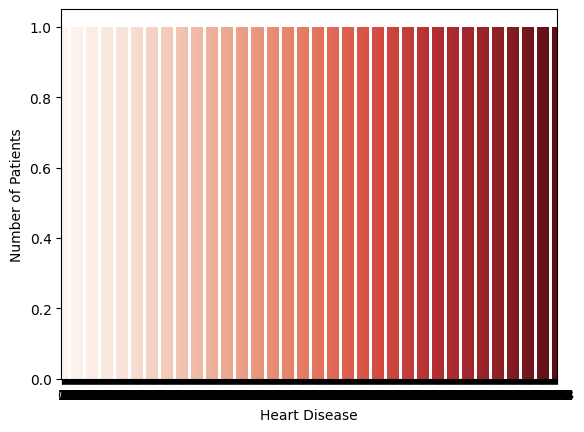


The number of patients suffering from heart disease is: 526 out of 1025 which is 51.32 % of the total sample.



In [8]:
sns.countplot(df.heart_disease,palette='Reds')
plt.xlabel('Heart Disease')
plt.ylabel('Number of Patients')
plt.show()
print('')
print('The number of patients suffering from heart disease is:', df.heart_disease.value_counts()[1],'out of',len(df.heart_disease),'which is',np.round((df.heart_disease.value_counts()[1]/len(df.heart_disease))*100,decimals=2),'% of the total sample.')
print('')

As we can see here we have more patients with heart disease than those without. This poses a problem for us when developing our machine learning models as we have an imbalanced target class. This can be solved with undersampling or oversampling techniques such as SMOTE.

Let's start by looking at another class of data in our dataframe, gender.

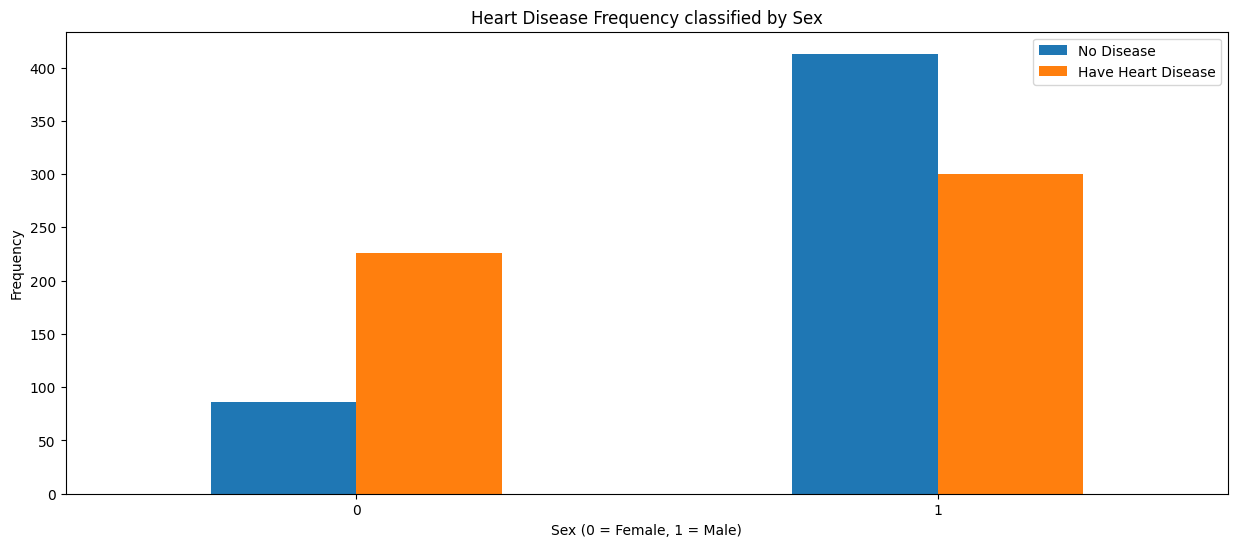

In [9]:
# Computing a simple crosstabulation to visualize presence of heart disease based on sex.
pd.crosstab(df.sex,df.heart_disease).plot(kind="bar",figsize=(15,6))
plt.title('Heart Disease Frequency classified by Sex')
plt.xlabel('Sex (0 = Female, 1 = Male)')
plt.xticks(rotation=0)
plt.legend(["No Disease", "Have Heart Disease"])
plt.ylabel('Frequency')
plt.show()

We can see that our data has more females with heart disease when compared to those without, but less than both male classes. Inversely, males with no heart disease are more prevalent than those with heart disease.

Text(0.5, 0, 'Maximum Recorded Heart Rate')

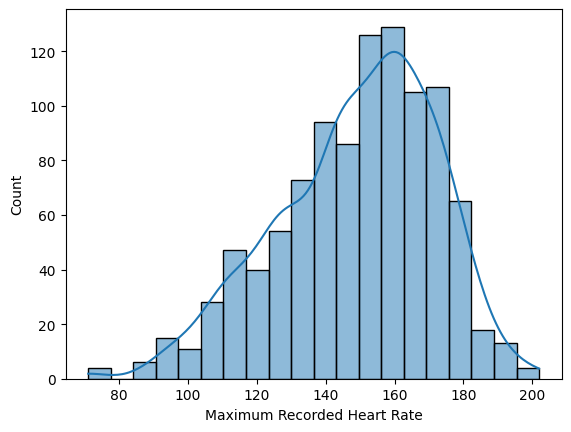

In [10]:
# Creating a simple histplot using seaborn of maximum heartrate variable.
sns.histplot(df.max_hr, kde=True)
# Labeling x-axis.
plt.xlabel('Maximum Recorded Heart Rate')

Normality is not evident in our continuous variable maximum heart rate. We need to validate this statistically before continuing.

Next, we will use the Shapiro-Wilke test to validate normality of the maximum heart rate variable. 

Statistical tests for normality are more accurate than visual tests since actual
probabilities are formed during calucation. 

Tests for normality calculate the probability that the sample was
drawn from a normal population. The hypotheses formed are:

* 𝐻𝑜:  Data IS Normal
* 𝐻𝑎: Data IS NOT Normal

In [11]:
t,p=stats.shapiro(df.max_hr)
print('Since the p-value,',np.round(p,decimals=4),'is less than 0.05, we reject the Null Hypothesis. This implies data deviation from being normal.')

Since the p-value, 0.0 is less than 0.05, we reject the Null Hypothesis. This implies data deviation from being normal.


In [12]:
print('The data is left-skewed with a Kurtosis of:',np.round(df.max_hr.kurtosis(),decimals=4))

The data is left-skewed with a Kurtosis of: -0.0888


As suspected our maximum heart rate variable is not distributed normally and is left-skewed with a kurtosis of -0.062. 

Pearson correlation is a statistic that measures the linear correlation between two variables X and Y. It has a value between +1 and −1. A value of +1 is total positive linear correlation, 0 is no linear correlation, and −1 is total negative linear correlation. We will look at the pearson correlation value of the presence of heart disease and the maximum heart rate. 

In [13]:
print("The pearson's correlation between heart disease and max heart rate is", np.round(df.heart_disease.corr(other=df.max_hr),decimals=4))

The pearson's correlation between heart disease and max heart rate is 0.4229


The pearon's correlation value calculated indicates a positive correlation between heart disease and the maximum heart rate. 

Since the presence of heart disease and maximum heart rate are positively correlated, the chances of having heart disease increase with increase in heart rate.

**Hypothesis test of mean heart rate of patients with and without heart disease:**

𝐻0:𝜇𝐻𝑒𝑎𝑟𝑡𝑅𝑎𝑡𝑒𝑂𝑓𝐻𝑒𝑎𝑟𝑡𝐷𝑖𝑠𝑒𝑎𝑠𝑒=𝜇𝐻𝑒𝑎𝑟𝑡𝑅𝑎𝑡𝑒𝑂𝑓𝑁𝑜𝐻𝑒𝑎𝑟𝑡𝐷𝑖𝑠𝑒𝑎𝑠𝑒 

𝐻0:𝜇𝐻𝑒𝑎𝑟𝑡𝑅𝑎𝑡𝑒𝑂𝑓𝐻𝑒𝑎𝑟𝑡𝐷𝑖𝑠𝑒𝑎𝑠𝑒!=𝜇𝐻𝑒𝑎𝑟𝑡𝑅𝑎𝑡𝑒𝑂𝑓𝑁𝑜𝐻𝑒𝑎𝑟𝑡𝐷𝑖𝑠𝑒𝑎𝑠𝑒 

In [14]:
# Forming two groups and testing for normality of both the groups reprenting presence of heart disease.
g1=df[df.heart_disease==0]
g2=df[df.heart_disease==1]
t1,p1=stats.shapiro(g1.max_hr)
t2,p2=stats.shapiro(g2.max_hr)
print('The p-value for shapiro test of group 1 :',np.round(p1,decimals=4))
print('The p-value for shapiro test of group 2 :',np.round(p2,decimals=4))

The p-value for shapiro test of group 1 : 0.0004
The p-value for shapiro test of group 2 : 0.0


The distribution of the first group is normal with a p-value greater than 0.05. Our second group's distribution however is not normal with a p-value less than 0.05.

In [15]:
# Performing Mann-Whitney U test on our target variable's classes. 
t,p=stats.mannwhitneyu(g1.chol,g2.chol)
print('The p-value for Mannwhitneyu test :',np.round(p,decimals=4))

The p-value for Mannwhitneyu test : 0.0


The Mann-Whitney U test yielsd a p-value is less than 0.05, we reject the null and state that the mean heart rates of both the groups is NOT the same.



In [16]:
# Finding the mean maximum heart rate of each class using newly formed groups. 
print('The mean heart rate of patients without a heart disease:',np.round(g1.max_hr.mean(),decimals=2))
print('The mean heart rate of patients with a heart disease:',np.round(g2.max_hr.mean(),decimals=2))

The mean heart rate of patients without a heart disease: 139.13
The mean heart rate of patients with a heart disease: 158.59


We can see here that the mean heart rate in patients with heart disease is elevated in comparison to those without by roughly 20 BPM (beats per minute).

In [17]:
# Creating dependent variable.
X=df.max_hr
# Creating target variable, heart disease.
Y=df.heart_disease
# Adding constant to logistic regression model.
XC=sm.add_constant(X,has_constant = 'add')
# Fitting model to target variable, dependent variable and newly created constant.
result=sm.Logit(Y,XC).fit()
# Printing model result summary.
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.594933
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:          heart_disease   No. Observations:                 1025
Model:                          Logit   Df Residuals:                     1023
Method:                           MLE   Df Model:                            1
Date:                Sun, 22 Feb 2026   Pseudo R-squ.:                  0.1413
Time:                        19:08:00   Log-Likelihood:                -609.81
converged:                       True   LL-Null:                       -710.12
Covariance Type:            nonrobust   LLR p-value:                 1.523e-45
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.5831      0.542    -12.152      0.000      -7.645      -5.521
max_hr         0.0444      0.

By running a simple logistic regression model we can see that for every unit increase in maximum heart rate there is a 4.4% increase in the probability of having heart disease.

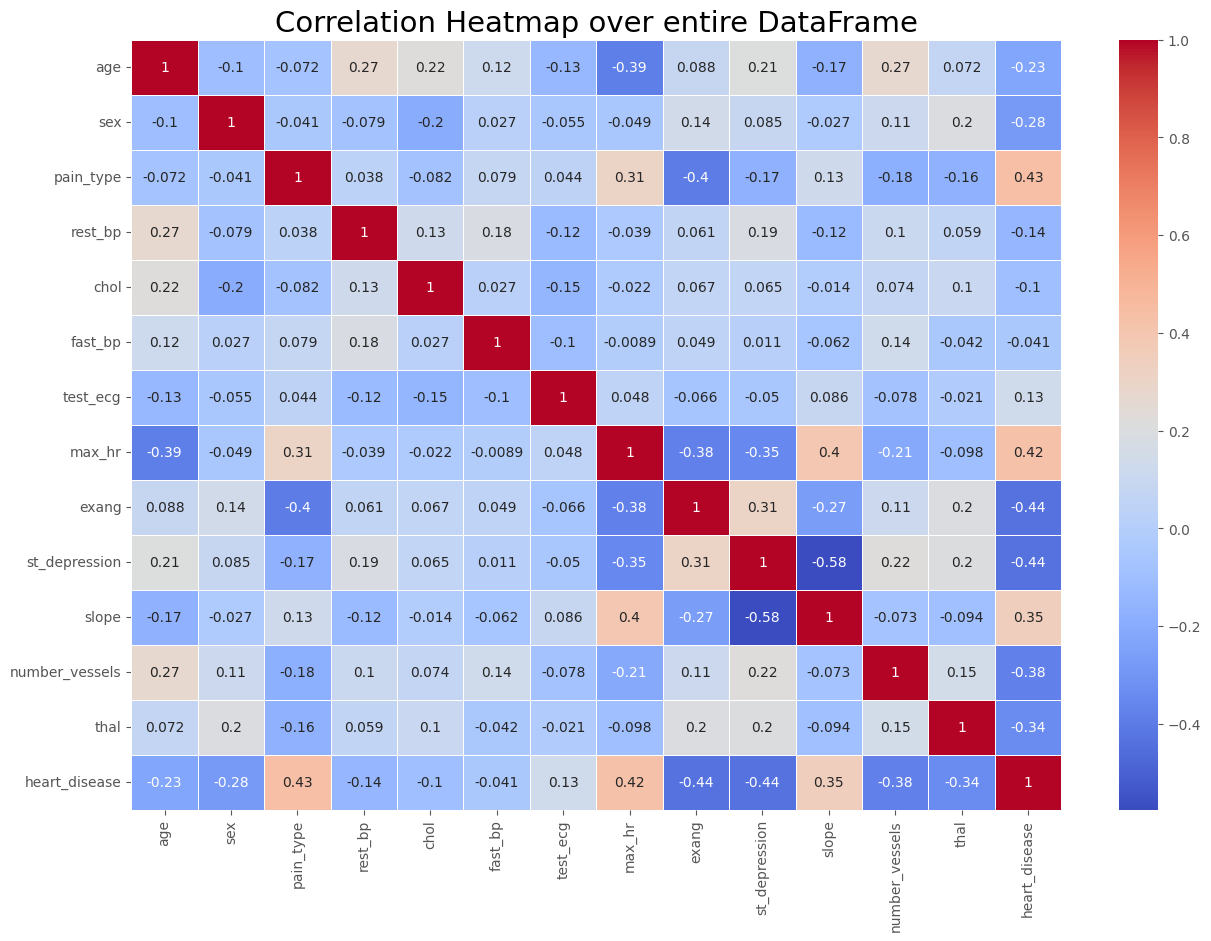

In [18]:
# Creating a heat map for all DataFrame features.
plt.rcParams['figure.figsize'] = (15, 10)
plt.style.use('ggplot')

sns.heatmap(df.corr(), annot = True, cmap = 'coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap over entire DataFrame', fontsize = 21)
plt.show()

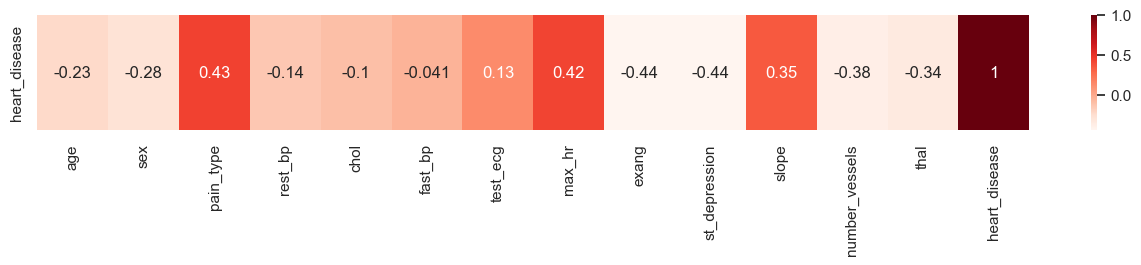

In [19]:
# Correlation heatmap with isolated target variable.
sns.set(rc={'figure.figsize':(16,1.5)})
sns.heatmap(pd.DataFrame(pd.DataFrame(df.corr()).heart_disease).T,annot=True, cmap='Reds')
plt.show()

Here we can see that across all features our target variable is displaying some interesting correlations. Unlike the direction usual clinical interpretations lean torwards, age and sex has a negative correlation in this data. The most correlated features with the presence of heart disease include pain type, and maximum heart rate, as well as the slope of the peak exercise ST segment measured. The ST segment is an interval of the heart cycle between ventricular depolarization and ventricular repolarization. Test ECG also displayed a weak positive correlation.

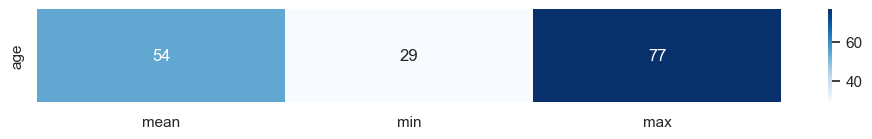

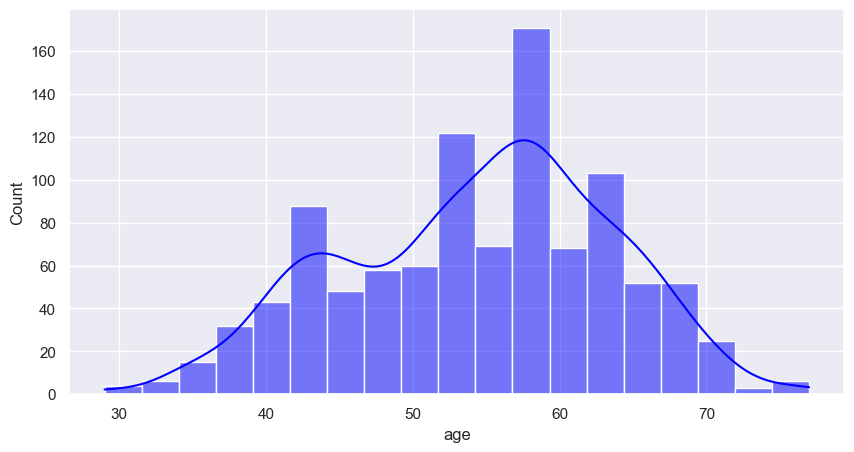

In [20]:
sns.set(rc={'figure.figsize':(12,1.2)})
# Creating heatmap of age variable's mean, min., and max. values.
sns.heatmap((pd.DataFrame(df.age.describe()).T)[['mean', 'min', 'max']], annot=True,  cmap='Blues')
plt.show()
print('')
sns.set(rc={'figure.figsize':(10,5)})
# Creating histplot to visualize distribution of age variable.
sns.histplot(df.age, color='blue', kde=True)
plt.show()

The mean age displayed in this heart disease data is 54 with most of the distribution curve showing older patients. The maximum age displayed is 77. We will further explore correlation involved with age and our target variable heart disease.


In [21]:
print("The pearson's correlation between heart disease and age is", np.round(df.heart_disease.corr(other=df.age),decimals=4))

The pearson's correlation between heart disease and age is -0.2293


Here we are individually testing the pearson correlation value of our target variable and age. As expected, we have the same value seen above in our correlation matrix heatmap displaying a negative correlation between age and heart disease. This means the chances of heart disease decrease with age in this dataset. 

**Hypothesis test of mean age of patients with and without heart disease**

𝐻0:𝜇𝐴𝑔𝑒𝑂𝑓𝐻𝑒𝑎𝑟𝑡𝑑𝑖𝑠𝑒𝑎𝑠𝑒=𝜇𝐴𝑔𝑒𝑂𝑓𝑁𝑜𝐻𝑒𝑎𝑟𝑡𝑑𝑖𝑠𝑒𝑎𝑠𝑒 

𝐻0:𝜇𝐴𝑔𝑒𝑂𝑓𝐻𝑒𝑎𝑟𝑡𝑑𝑖𝑠𝑒𝑎𝑠𝑒!=𝜇𝐴𝑔𝑒𝑂𝑓𝑁𝑜𝐻𝑒𝑎𝑟𝑡𝑑𝑖𝑠𝑒𝑎𝑠𝑒 

Forming two groups and testing for normality of both the groups.

In [22]:
g1=df[df.heart_disease==0]
g2=df[df.heart_disease==1]
t1,p1=stats.shapiro(g1.age)
t2,p2=stats.shapiro(g2.age)
print('The p-value for shapiro test of group 1 :',np.round(p1,decimals=4))
print('The p-value for shapiro test of group 2 :',np.round(p2,decimals=4))

The p-value for shapiro test of group 1 : 0.0
The p-value for shapiro test of group 2 : 0.0001


Because only the first group is displaying a p-value of less than 0.05, we can reject the null hypothesis and conclude that the second class has a distribution that is not normal.

Next, we will perform a Mann-Whitney U test to find if the mean of both the group are the same or not.

In [23]:
t,p=stats.mannwhitneyu(g1.age,g2.age)
print('The p-value for Mannwhitneyu test :',np.round(p,decimals=10))

The p-value for Mannwhitneyu test : 0.0


Since the p-value dispayed is less than 0.05, we can reject the null hypothesis and conclude that the mean age of both groups is not the same.

Next, post-hoc analysis can be performed to analyze the mean age of both classes.

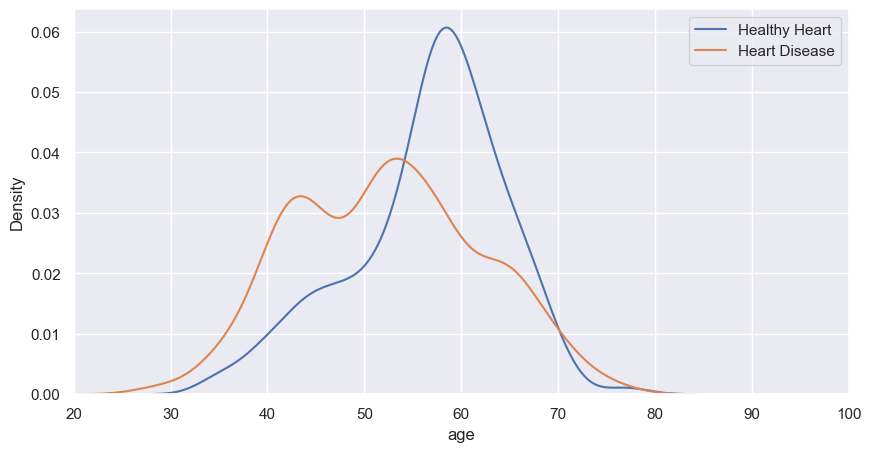

In [24]:
# Creating first group with heart disease.
df_age_target = df[df.heart_disease == 1]
df_age_target = df_age_target[['age','heart_disease']]

# Creating second group without heart disease.
df_age_target_0 = df[df.heart_disease == 0]
df_age_target_0 = df_age_target_0[['age','heart_disease']]

# Forming subplots.
fig, ax = plt.subplots()
# Labeling and plotting histplot for each group.
sns.kdeplot(df_age_target_0.age, label='Healthy Heart')
sns.kdeplot(df_age_target.age, label='Heart Disease')

ax.set_xlim(20,100)
plt.legend()
plt.show()

In [25]:
print('The mean age of patients with heart disease:',np.round(df_age_target.mean(),decimals=2))
print('The mean age of patients without heart disease:',np.round(df_age_target_0.mean(),decimals=2))

The mean age of patients with heart disease: age              52.41
heart_disease     1.00
dtype: float64
The mean age of patients without heart disease: age              56.57
heart_disease     0.00
dtype: float64


The mean age of patients with heart disease is less than those without.

In [26]:
# Examining logistic regress model coefficients.
X=df.age
Y=df.heart_disease
XC=sm.add_constant(X)
result=sm.Logit(Y,XC).fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.665886
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:          heart_disease   No. Observations:                 1025
Model:                          Logit   Df Residuals:                     1023
Method:                           MLE   Df Model:                            1
Date:                Sun, 22 Feb 2026   Pseudo R-squ.:                 0.03885
Time:                        19:08:02   Log-Likelihood:                -682.53
converged:                       True   LL-Null:                       -710.12
Covariance Type:            nonrobust   LLR p-value:                 1.103e-13
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9430      0.408      7.205      0.000       2.142       3.744
age           -0.0530      0.

So, we can conclude that with each year increase in age from minimum age (29),there is a 5.2 % decrease in probablity of a heart disease. This means younger population groups in this dataset are more susceptible to heart disease than older age groups. 

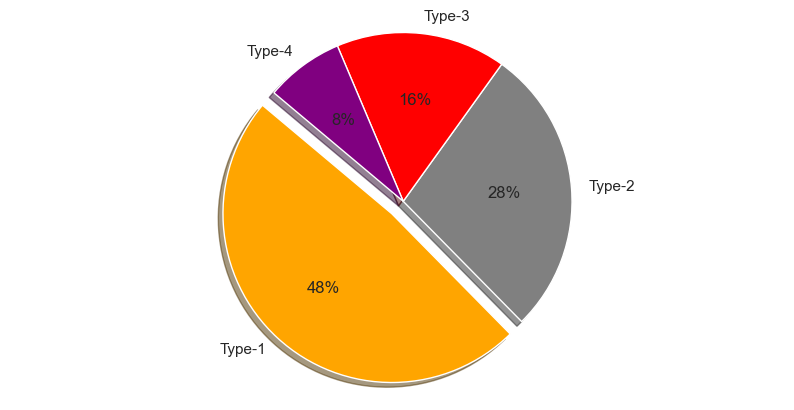

In [27]:
# Plotting chest pain pie chart.
labels = 'Type-1', 'Type-2', 'Type-3', 'Type-4'
counts = list(df.pain_type.value_counts().values)
colors = ['orange', 'grey', 'red', 'purple']
explode = (0.1, 0, 0, 0)  # explode 1st slice
plt.pie(counts, explode=explode, labels=labels, colors=colors,
autopct='%1.0f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

The majority of chest pain reported was of type 1 intensity, with the second most reported type being type 2 chest pain.

In [28]:
print('The max heart rate achieved in non heart disease patients is :',max(df[df.heart_disease==0].max_hr),'bpm')
print('The max heart rate achieved in heart disease patients is :',max(df[df.heart_disease==1].max_hr),'bpm')

The max heart rate achieved in non heart disease patients is : 195 bpm
The max heart rate achieved in heart disease patients is : 202 bpm


Maximum heart rate achieved is higher in heart disease patients.

# Machine Learning Models

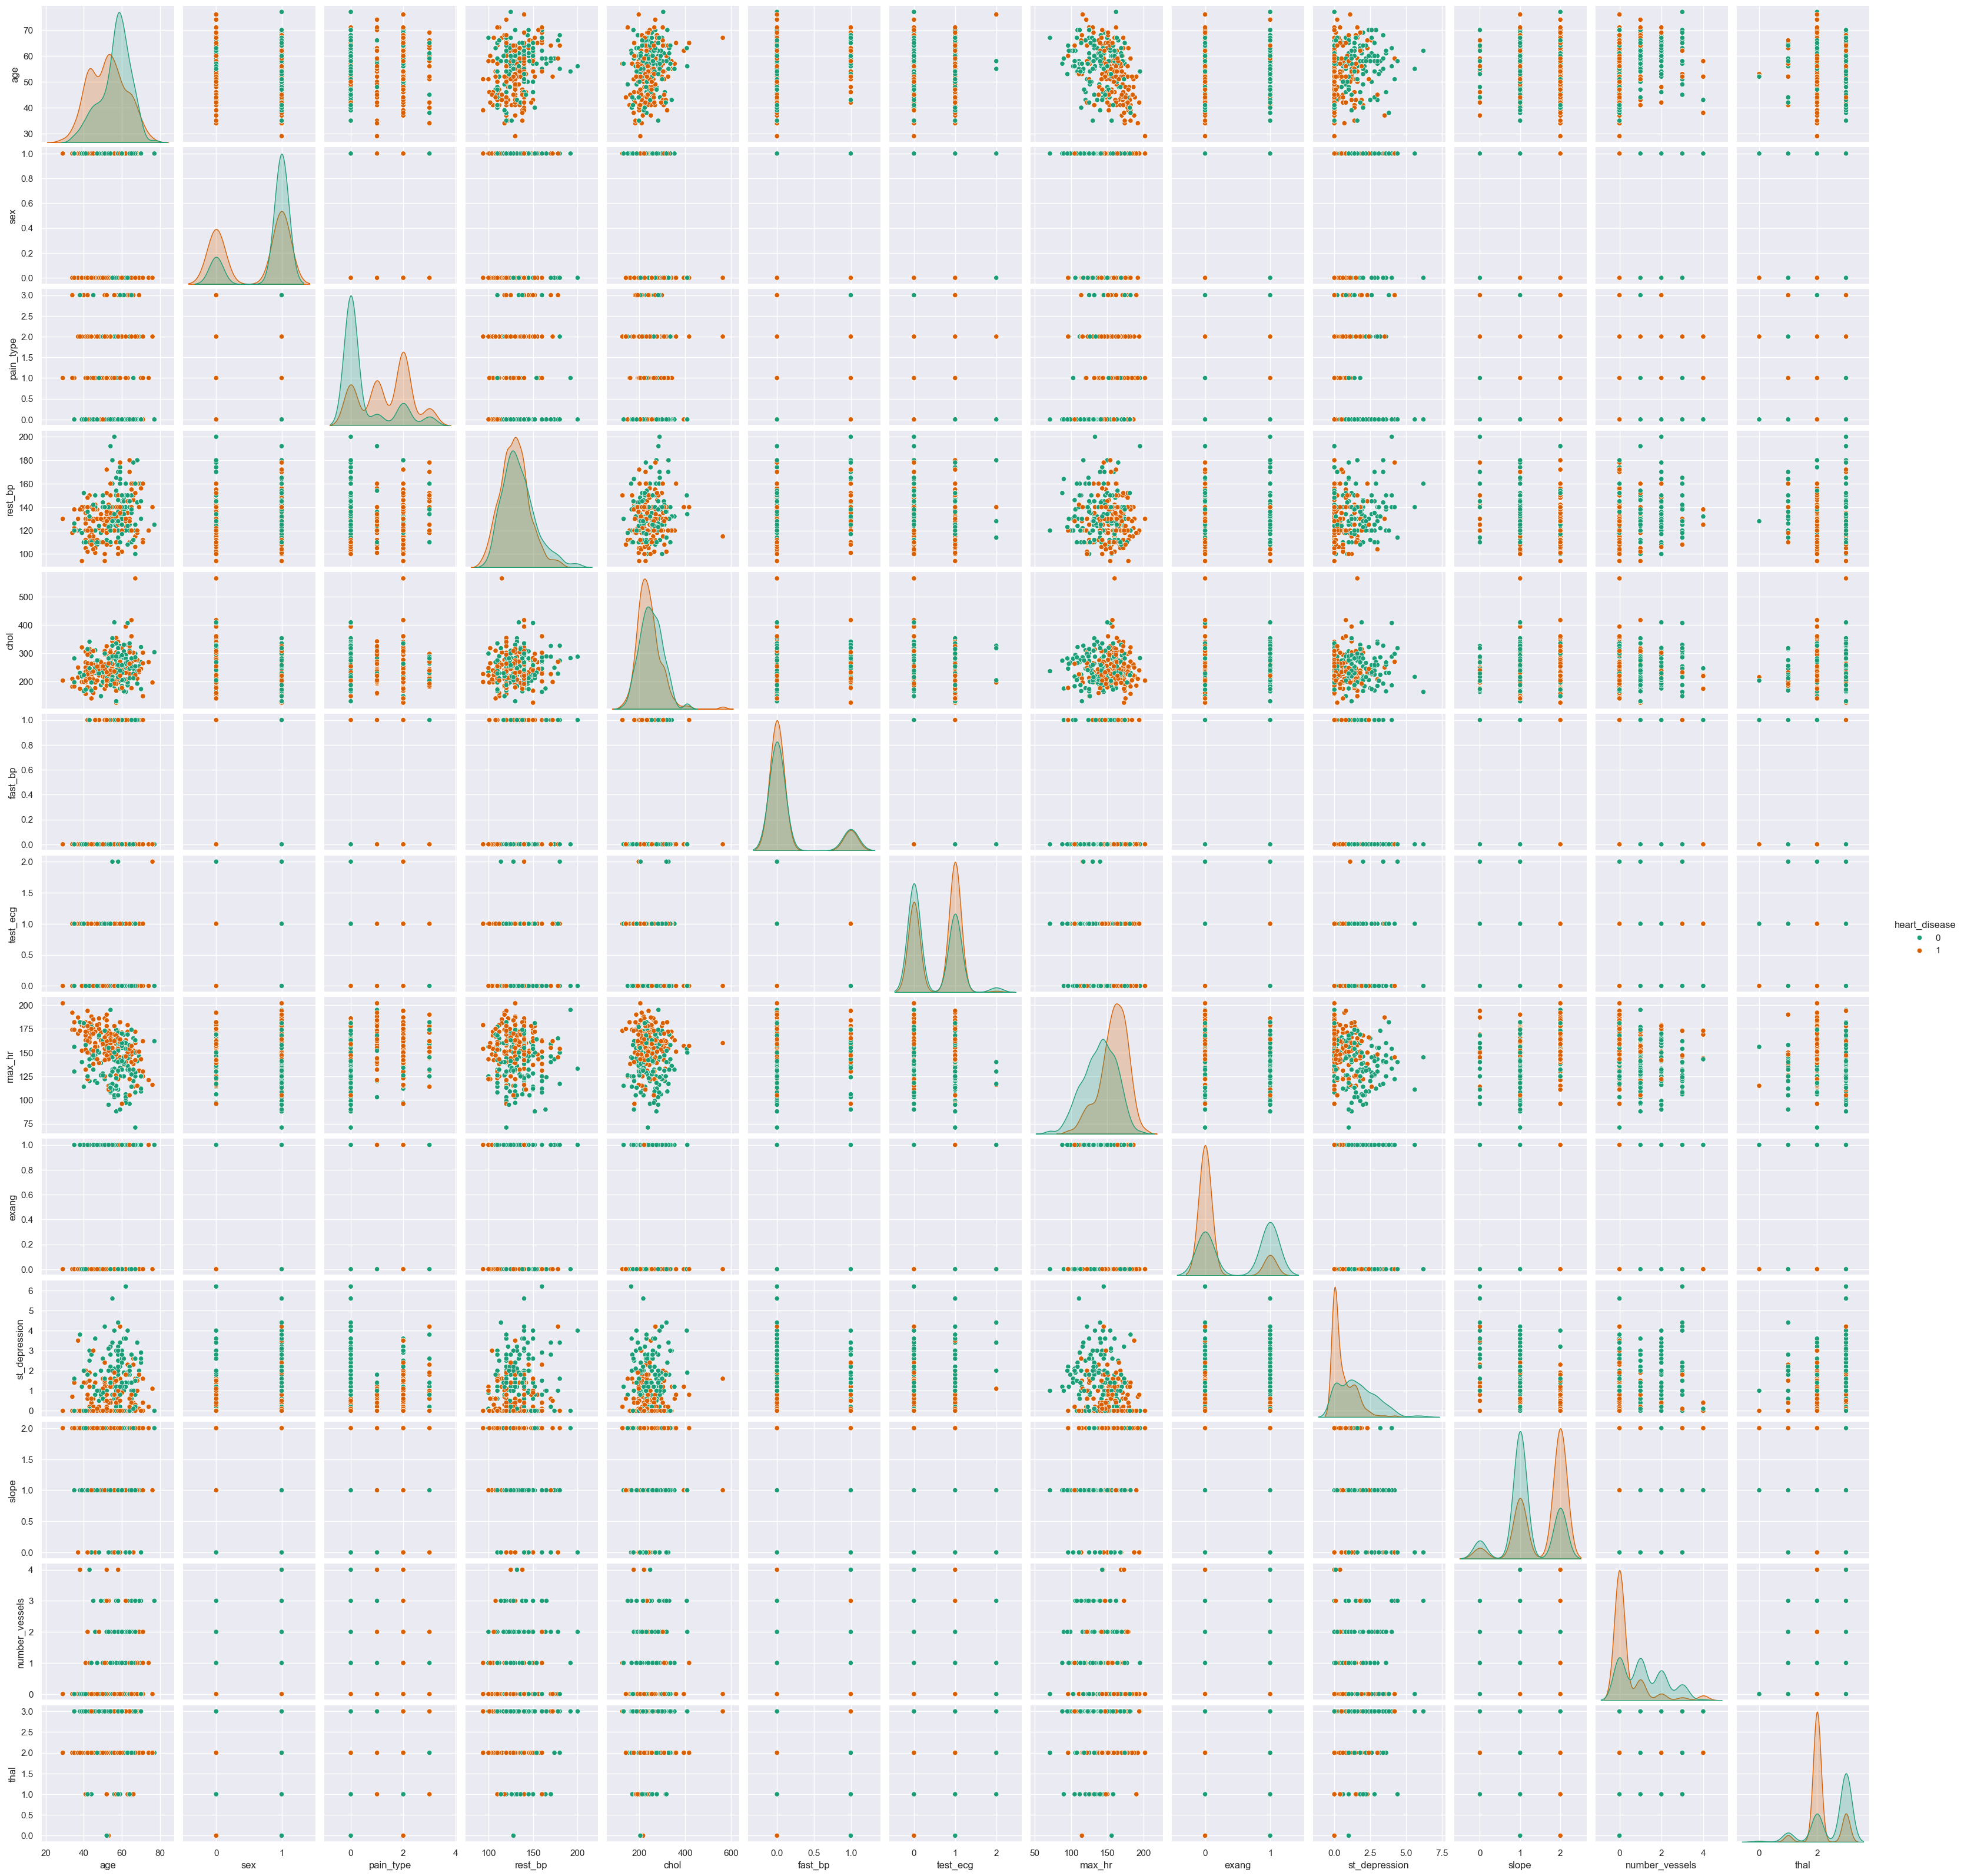

In [29]:
# Before we implement any ML models - we want to see if we can find any pattern between target variable and other features visually.
sns.pairplot(df,hue='heart_disease',palette='Dark2')

In [30]:
# Create our target variable y by isolating heart disease variable from DataFrame.
y = df['heart_disease']

# Create X values by dropping our target variable, heart disease, from the rest of the DataFrame.
X = df.drop(columns=['heart_disease'])

In [31]:
# Using sklearns train_test_split to split data into random train and test subsets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

Now that we have split our data into training and test sets, we are ready to create and test the performance of our machine learning models.

# SVM Classifier

In [32]:
# Timing our model.
start_time = time.time()

#Create svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train our model
clf.fit(X_train, y_train)

# Print model time. 
print("--- %s seconds ---" % round(time.time() - start_time, 3))

--- 4.681 seconds ---


In [33]:
# Cross validation score for SVM.
cross_val_score(clf, X_train, y_train, cv=10)

array([0.8902439 , 0.84146341, 0.84146341, 0.84146341, 0.82926829,
       0.85365854, 0.92682927, 0.81707317, 0.86585366, 0.81707317])

In [34]:
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[70 30]
 [ 8 97]]
              precision    recall  f1-score   support

           0       0.90      0.70      0.79       100
           1       0.76      0.92      0.84       105

    accuracy                           0.81       205
   macro avg       0.83      0.81      0.81       205
weighted avg       0.83      0.81      0.81       205



In [35]:
# Using GridSearchCV to find optimized hyperparameters for best model outcome.
from sklearn.model_selection import learning_curve,GridSearchCV
param_grid = {'C':[0.1,1,10,100],'gamma':[1,0.1,0.01,0.001]}
grid = GridSearchCV(SVC(),param_grid, verbose=2)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s


[CV] END .....................................C=0.1, gamma=1; total time=   0.0s


[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s


[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s


[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.0s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.0s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.0s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.0s


[CV] END ..................................C=0.1, gamma=0.01; total time=   0.0s


[CV] END .................................C=0.1, gamma=0.001; total time=   0.0s
[CV] END .................................C=0.1, gamma=0.001; total time=   0.0s
[CV] END .................................C=0.1, gamma=0.001; total time=   0.0s
[CV] END .................................C=0.1, gamma=0.001; total time=   0.0s
[CV] END .................................C=0.1, gamma=0.001; total time=   0.0s
[CV] END .......................................C=1, gamma=1; total time=   0.0s


[CV] END .......................................C=1, gamma=1; total time=   0.0s
[CV] END .......................................C=1, gamma=1; total time=   0.0s
[CV] END .......................................C=1, gamma=1; total time=   0.0s
[CV] END .......................................C=1, gamma=1; total time=   0.0s
[CV] END .....................................C=1, gamma=0.1; total time=   0.0s
[CV] END .....................................C=1, gamma=0.1; total time=   0.0s
[CV] END .....................................C=1, gamma=0.1; total time=   0.0s


[CV] END .....................................C=1, gamma=0.1; total time=   0.0s
[CV] END .....................................C=1, gamma=0.1; total time=   0.0s
[CV] END ....................................C=1, gamma=0.01; total time=   0.0s
[CV] END ....................................C=1, gamma=0.01; total time=   0.0s
[CV] END ....................................C=1, gamma=0.01; total time=   0.0s
[CV] END ....................................C=1, gamma=0.01; total time=   0.0s
[CV] END ....................................C=1, gamma=0.01; total time=   0.0s


[CV] END ...................................C=1, gamma=0.001; total time=   0.0s
[CV] END ...................................C=1, gamma=0.001; total time=   0.0s
[CV] END ...................................C=1, gamma=0.001; total time=   0.0s
[CV] END ...................................C=1, gamma=0.001; total time=   0.0s
[CV] END ...................................C=1, gamma=0.001; total time=   0.0s
[CV] END ......................................C=10, gamma=1; total time=   0.0s
[CV] END ......................................C=10, gamma=1; total time=   0.0s


[CV] END ......................................C=10, gamma=1; total time=   0.0s
[CV] END ......................................C=10, gamma=1; total time=   0.0s
[CV] END ......................................C=10, gamma=1; total time=   0.0s
[CV] END ....................................C=10, gamma=0.1; total time=   0.0s
[CV] END ....................................C=10, gamma=0.1; total time=   0.0s
[CV] END ....................................C=10, gamma=0.1; total time=   0.0s
[CV] END ....................................C=10, gamma=0.1; total time=   0.0s


[CV] END ....................................C=10, gamma=0.1; total time=   0.0s
[CV] END ...................................C=10, gamma=0.01; total time=   0.0s
[CV] END ...................................C=10, gamma=0.01; total time=   0.0s
[CV] END ...................................C=10, gamma=0.01; total time=   0.0s
[CV] END ...................................C=10, gamma=0.01; total time=   0.0s
[CV] END ...................................C=10, gamma=0.01; total time=   0.0s
[CV] END ..................................C=10, gamma=0.001; total time=   0.0s


[CV] END ..................................C=10, gamma=0.001; total time=   0.0s
[CV] END ..................................C=10, gamma=0.001; total time=   0.0s
[CV] END ..................................C=10, gamma=0.001; total time=   0.0s
[CV] END ..................................C=10, gamma=0.001; total time=   0.0s
[CV] END .....................................C=100, gamma=1; total time=   0.0s
[CV] END .....................................C=100, gamma=1; total time=   0.0s
[CV] END .....................................C=100, gamma=1; total time=   0.0s


[CV] END .....................................C=100, gamma=1; total time=   0.0s
[CV] END .....................................C=100, gamma=1; total time=   0.0s
[CV] END ...................................C=100, gamma=0.1; total time=   0.0s
[CV] END ...................................C=100, gamma=0.1; total time=   0.0s
[CV] END ...................................C=100, gamma=0.1; total time=   0.0s
[CV] END ...................................C=100, gamma=0.1; total time=   0.0s
[CV] END ...................................C=100, gamma=0.1; total time=   0.0s
[CV] END ..................................C=100, gamma=0.01; total time=   0.0s


[CV] END ..................................C=100, gamma=0.01; total time=   0.0s
[CV] END ..................................C=100, gamma=0.01; total time=   0.0s
[CV] END ..................................C=100, gamma=0.01; total time=   0.0s
[CV] END ..................................C=100, gamma=0.01; total time=   0.0s
[CV] END .................................C=100, gamma=0.001; total time=   0.0s
[CV] END .................................C=100, gamma=0.001; total time=   0.0s


[CV] END .................................C=100, gamma=0.001; total time=   0.0s
[CV] END .................................C=100, gamma=0.001; total time=   0.0s
[CV] END .................................C=100, gamma=0.001; total time=   0.0s


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",SVC()
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'C': [0.1, 1, ...], 'gamma': [1, 0.1, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",None
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score is also displayed;- >3 : the fold and candidate parameter 

In [36]:
grid_predictions = grid.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[70 30]
 [ 8 97]]
              precision    recall  f1-score   support

           0       0.90      0.70      0.79       100
           1       0.76      0.92      0.84       105

    accuracy                           0.81       205
   macro avg       0.83      0.81      0.81       205
weighted avg       0.83      0.81      0.81       205



The model seems to be fairly optimized initially and does not benefit from GridSearchCV in this case.

# Decision Tree Classifier with GridSearchCV

In [37]:
# Creating initial tree for GridSearchCV to run.
decision_tree = tree.DecisionTreeClassifier()

# We are looking at a few parameters to see what works best with our model.
tree_para = {'criterion':['gini','entropy'],
             'max_depth':[5,10,20,50],
             'max_features':[1,5,10,14]}
clf = GridSearchCV(decision_tree, tree_para, cv=5)
clf.fit(X_train, y_train)

# Putting our results into a Pandas DataFrame for easier interpretation.
gscv_df = pd.DataFrame(clf.cv_results_)
gscv_df.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
30,0.007095,0.002041,0.004254,0.002444,entropy,50,10,"{'criterion': 'entropy', 'max_depth': 50, 'max...",1.000000,0.981707,0.987805,0.993902,1.000000,0.992683,0.007111,1
27,0.010473,0.005445,0.003157,0.000341,entropy,20,14,"{'criterion': 'entropy', 'max_depth': 20, 'max...",0.993902,0.987805,0.987805,0.981707,1.000000,0.990244,0.006218,2
31,0.006706,0.001022,0.003541,0.000897,entropy,50,14,"{'criterion': 'entropy', 'max_depth': 50, 'max...",0.993902,0.987805,0.987805,0.981707,1.000000,0.990244,0.006218,2
22,0.005999,0.000122,0.002970,0.000312,entropy,10,10,"{'criterion': 'entropy', 'max_depth': 10, 'max...",0.993902,0.987805,0.987805,0.975610,1.000000,0.989024,0.008089,4
25,0.007503,0.003758,0.003796,0.001217,entropy,20,5,"{'criterion': 'entropy', 'max_depth': 20, 'max...",0.993902,0.981707,1.000000,0.963415,1.000000,0.987805,0.013905,5
15,0.006012,0.000956,0.002913,0.000351,gini,50,14,"{'criterion': 'gini', 'max_depth': 50, 'max_fe...",0.987805,0.987805,0.987805,0.969512,1.000000,0.986585,0.009756,6
11,0.007283,0.001022,0.003537,0.000759,gini,20,14,"{'criterion': 'gini', 'max_depth': 20, 'max_fe...",0.987805,0.987805,0.987805,0.969512,1.000000,0.986585,0.009756,6
6,0.005825,0.000520,0.003717,0.001075,gini,10,10,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...",0.981707,0.993902,0.987805,0.963415,1.000000,0.985366,0.012556,8
9,0.005148,0.001323,0.004222,0.001508,gini,20,5,"{'criterion': 'gini', 'max_depth': 20, 'max_fe...",0.987805,0.987805,0.981707,0.981707,0.987805,0.985366,0.002987,9
7,0.007096,0.001182,0.003892,0.000543,gini,10,14,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...",0.987805,0.987805,0.987805,0.957317,1.000000,0.984146,0.014222,10


In [38]:
# Timing our model.
start_time = time.time()

# Initialize and train our tree using best parameters from GridSearchCV.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=5,
    max_features=5,
)
decision_tree.fit(X_train, y_train)

# Print model runtime. 
print("--- %s seconds ---" % round(time.time() - start_time, 3))

--- 0.003 seconds ---


In [39]:
# Print cross-validation scoring.
cross_val_score(decision_tree, X_train, y_train, cv=10)

array([0.86585366, 0.75609756, 0.81707317, 0.82926829, 0.81707317,
       0.90243902, 0.86585366, 0.85365854, 0.86585366, 0.80487805])

Cross-validation scoring is varied as expected with such a small dataset. More data collection will increase cross-validation scoring displayed as the model has more data to train on. Still here we see that only a couple of cross-validation scores displayed began to show signs of underfitting with lower training scores of .66 and .70 displaying compared to our classification report metrics shown below.

In [40]:
# Print confusion matrix and classification report metrics for our Decision Tree classification model.
y_pred = decision_tree.predict(X_test)
dt_accuracy = accuracy_score(y_test,y_pred)
decision_tree_report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy: ", dt_accuracy)
print("Classification report:")
print(decision_tree_report)
print("Confusion matrix:")
print(cm)

Accuracy:  0.8585365853658536
Classification report:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       100
           1       0.85      0.89      0.87       105

    accuracy                           0.86       205
   macro avg       0.86      0.86      0.86       205
weighted avg       0.86      0.86      0.86       205

Confusion matrix:
[[83 17]
 [12 93]]


In [41]:
# Feature names will be all X columns 
feature_names = X.columns

# Class names will be our target variable
y_train_str = y_train.astype('str')

dot_data = tree.export_graphviz(decision_tree, out_file=None, filled=True, rounded=True,
                                feature_names=feature_names,  
                                class_names=y_train_str)
graph = graphviz.Source(dot_data)  
graph

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

# Random Forest Classifier

In [42]:
# Creating a Random Forest Classifier to use with GridSearchCV.
rfc = ensemble.RandomForestClassifier()

# Creating a parameter grid to find best combination of hyperparameters. 
param_grid = { 
    'n_estimators': [5,100,500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [3,6,14],
    'criterion' :['gini', 'entropy']
}

# Using GridSearchCV to find best hyperparamater combination.
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)

# Fitting GridSearchCV to our newly decomposed data.
CV_rfc.fit(X_train, y_train)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestClassifier()
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'criterion': ['gini', 'entropy'], 'max_depth': [3, 6, ...], 'max_features': ['sqrt', 'log2'], 'n_estimators': [5, 100, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter c

In [43]:
# Calling best_params_ to find best parameters from GridSearchCV.
CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 14,
 'max_features': 'log2',
 'n_estimators': 100}

In [44]:
# Timing our model.
start_time = time.time()

# Creating our model using optimized hyperparameters from GridSearchCV.
rfc = ensemble.RandomForestClassifier(criterion='gini', 
                                      max_depth=3,
                                      max_features='sqrt',
                                      n_estimators=500, random_state=42)

# Fit our newly decomposed data to our model.
rfc.fit(X_train, y_train)

# Print model time. 
print("--- %s seconds ---" % round(time.time() - start_time, 3))

--- 0.997 seconds ---


In [45]:
# Cross-valdiation score for our Random Forest Classifier.
cross_val_score(rfc, X_train, y_train, cv=10)

array([0.96341463, 0.81707317, 0.90243902, 0.86585366, 0.87804878,
       0.87804878, 0.8902439 , 0.85365854, 0.84146341, 0.82926829])

The cross-validation scoring showed here for our random forest model is much higher and more consistent with little sign of underfitting when compared to the decision tree classifier above. This is because random forest is computationally more intensive and creates an ensemble of multiple decision trees that is often more powerful than a lone decision tree. However, this is not always the case depending on the dataset which is why it is important to validate and test multiple models in order to achieve optimum results.

In [46]:
# Print classification report for Random Forest Classifier.
y_pred = rfc.predict(X_test) 
rfc_accuracy = accuracy_score(y_test,y_pred)
rfc_report = classification_report(y_test, y_pred)
rfc_cm = confusion_matrix(y_test, y_pred)

print("Classification report:")
print("Accuracy: ", rfc_accuracy)
print(rfc_report)
print("Confusion matrix:")
print(rfc_cm)

Classification report:
Accuracy:  0.8585365853658536
              precision    recall  f1-score   support

           0       0.91      0.79      0.84       100
           1       0.82      0.92      0.87       105

    accuracy                           0.86       205
   macro avg       0.87      0.86      0.86       205
weighted avg       0.86      0.86      0.86       205

Confusion matrix:
[[79 21]
 [ 8 97]]


<Axes: >

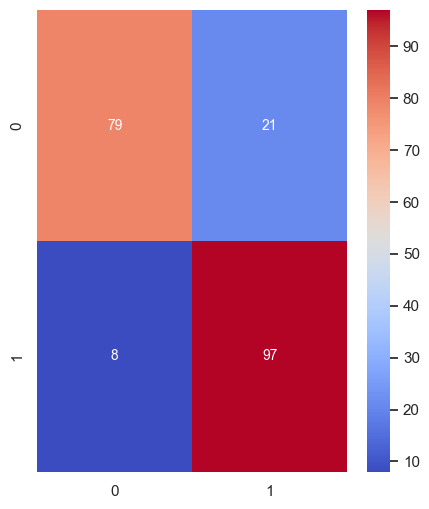

In [47]:
# cofusion matrix
plt.rcParams['figure.figsize'] = (5, 6)
sns.heatmap(rfc_cm, annot = True, annot_kws = {'size':10}, cmap = 'coolwarm')

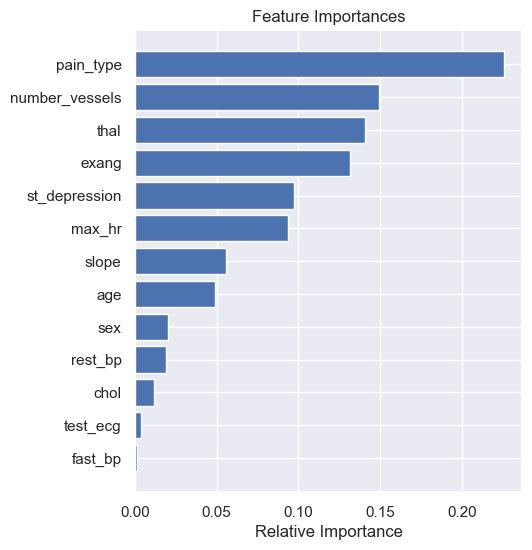

In [48]:
# Extracting features from X.
features = X.columns
# Pulling feature importances from random forest classifier.
importances = rfc.feature_importances_
# Creating indices by sorting feature importance values.
indices = np.argsort(importances)
# Creating visual plot using PyPlot.
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

We can see here that the random forest classification model has found the number of vessels, the pain type, and the presence of an abnormal thalium stress test result to be of significantly more importance than features such as age, sex, or cholesterol which are the usual presumptive suspects when diagnosing a heart disease. This shows us the power of machine learning to diagnose in ways beyond traditional assessments and can aid in early detection of heart disease.

# Model Deployment Using Jupyter Widget

In [49]:
User_Age =   37#@param {type:"integer"}

Male =  False#@param {type:"boolean"}         
Female = True#@param {type:"boolean"}

if Male:
  sex = 1
else:
  sex = 0 #female

Chest_pain_type = 1 #@param {type:"slider", min:0, max:3, step:1}
resting_bp = 127 #@param {type:"slider", min:94, max:200, step:1}
Serum_cholestoral = 329 #@param {type:"slider", min:125, max:500, step:1}

# fasting blood sugar > 120 mg/dl) (1 = true; 0 = false) 
fasting_blood_sugar = 0 #@param {type:"slider", min:0, max:1, step:1}

#restecg: resting electrocardiographic results
#-- Value 0: normal # Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
#-- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

resting_electrocardiographic = 1 #@param {type:"slider", min:0, max:2, step:1}
max_heart_rate = 162 #@param {type:"slider", min:70, max:210, step:1}

#exercise induced angina (1 = yes; 0 = no) 
exercise_angina =  0 #@param {type:"slider", min:0, max:1, step:1}

# oldpeak = ST depression induced by exercise relative to rest 
oldpeak = 1.6 #@param {type:"slider", min:0, max:6.5, step:0.1}

#slope: the slope of the peak exercise ST segment  #Value 1: upsloping   # Value 2: flat  #Value 3: downsloping 
slope =  1 #@param {type:"slider", min:1, max:3, step:1}

#ca: number of major vessels (0-3) colored by flouroscopy 
no_major_vessels =  1 #@param {type:"slider", min:0, max:4, step:1}

#thal: 0 = normal; 1 = fixed defect; 2 = reversable defect, 3 = permanent defect
thal =  3 #@param {type:"slider", min:0, max:3, step:1}


In [50]:
button = widgets.Button(description="Click for Results!")
output = widgets.Output()

def on_button_clicked(b):
  # Display the message within the output widget.
  with output:
    new_input = [[User_Age,sex,Chest_pain_type,resting_bp,Serum_cholestoral,fasting_blood_sugar,resting_electrocardiographic,max_heart_rate,exercise_angina,oldpeak,slope,no_major_vessels,thal]]
    #print(new_input)
    new_output = rfc.predict(new_input)
    if new_output == 0:
      print("Patient is heart healthy.")
    else:
      print("Possibility of heart disease detected, please schedule a follow-up appointment.")
    #print(new_output)
    #print("Button clicked.")

button.on_click(on_button_clicked)
display(button, output)

Button(description='Click for Results!', style=ButtonStyle())

Output()

In [51]:
# You can also pass a list with the corresponding values.
new_input = [[User_Age,sex,Chest_pain_type,resting_bp,Serum_cholestoral,fasting_blood_sugar,resting_electrocardiographic,max_heart_rate,exercise_angina,oldpeak,slope,no_major_vessels,thal]]
print(new_input)
new_output = rfc.predict(new_input)
# Output of 0 is a negative value corresponding with heart health. The presence of a 1 or positive value is indicative of heart disease.
print(new_output)

[[37, 0, 1, 127, 329, 0, 1, 162, 0, 1.6, 1, 1, 3]]
[1]


# Model Deployment using Flask

In [52]:
# Creating Flask application.
app = Flask(__name__)

@app.route("/")
def hello():
    new_input = [[User_Age,sex,Chest_pain_type,resting_bp,Serum_cholestoral,fasting_blood_sugar,resting_electrocardiographic,max_heart_rate,exercise_angina,oldpeak,slope,no_major_vessels,thal]]
    new_output = rfc.predict(new_input)
    new_output = new_output.astype(str)
    if new_output == '0':
      return "Patient is heart healthy."
    else:
      return "Possibility of heart disease detected, please schedule a follow-up appointment."
    
threading.Thread(target=app.run, kwargs={'host':'0.0.0.0','port':6060}).start()

 * Serving Flask app '__main__'


 * Debug mode: off


In [53]:
# Colab-only: embed Flask app iframe; no-op when run locally or in nbconvert
try:
    from IPython import display
    def _display_flask(port, height):
        shell = """
        (async () => {
            const url = await google.colab.kernel.proxyPort(%PORT%, {"cache": true});
            const iframe = document.createElement('iframe');
            iframe.src = url;
            iframe.setAttribute('width', '100%');
            iframe.setAttribute('height', '%HEIGHT%');
            iframe.setAttribute('frameborder', 0);
            document.body.appendChild(iframe);
        })();
    """
        replacements = [
            ("%PORT%", "%d" % port),
            ("%HEIGHT%", "%d" % height),
        ]
        for (k, v) in replacements:
            shell = shell.replace(k, v)
        script = display.Javascript(shell)
        display.display(script)
    _display_flask(6060, 100)
except Exception:
    pass  # Not in Colab

<IPython.core.display.Javascript object>

We can use Flask also to create a user based form on a private or public server to allow others to access the abilites of the predictive machine learning model. This could include a public health website, or privately for institutional or specialist use.

---

# Senior Analysis: Clinical Decision Support System

The exploratory analysis above establishes the clinical landscape. Below we build
a **clinical-grade prediction system** with the rigor expected for healthcare ML:

| Practice | Clinical rationale |
|---|---|
| **Pipeline** | FDA/regulatory audit trail requires reproducible preprocessing |
| **Stratified CV** | Ensures balanced disease prevalence in every evaluation fold |
| **Sensitivity focus** | Missing a heart disease case (false negative) can be fatal |
| **SHAP** | Clinicians need to understand *why* the model flags a patient |
| **Calibration** | Predicted probabilities must reflect true risk for clinical decisions |


In [54]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    cross_validate, StratifiedKFold, train_test_split
)
from sklearn.metrics import (
    classification_report, roc_auc_score,
    ConfusionMatrixDisplay, RocCurveDisplay,
    precision_recall_curve, brier_score_loss
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
    from portfolio_utils.data_loader import load_heart
    df_s = load_heart()
except Exception:
    df_s = df.copy() if 'df' in dir() else df_heart.copy()

target_col = 'target' if 'target' in df_s.columns else 'output'
y_s = df_s[target_col]
X_s = df_s.drop(columns=[target_col]).select_dtypes(include=[np.number])

print(f'Features: {X_s.shape[1]}, Samples: {X_s.shape[0]}')
print(f'Disease prevalence: {y_s.mean():.1%}')



 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:6060
 * Running on http://192.168.0.128:6060


Press CTRL+C to quit

Features: 13, Samples: 1025
Disease prevalence: 51.3%


In [55]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_s, y_s, test_size=0.2, stratify=y_s, random_state=42
)

models = {
    'Random Forest': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', RandomForestClassifier(n_estimators=200, random_state=42)),
    ]),
    'Gradient Boosting': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', GradientBoostingClassifier(random_state=42)),
    ]),
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1000, random_state=42)),
    ]),
    'SVM (RBF)': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', SVC(kernel='rbf', probability=True, random_state=42)),
    ]),
}

scoring = {'accuracy': 'accuracy', 'precision': 'precision', 'recall': 'recall',
           'f1': 'f1', 'roc_auc': 'roc_auc'}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}
for name, pipe in models.items():
    cv_res = cross_validate(pipe, X_train_s, y_train_s, cv=cv,
                            scoring=scoring, n_jobs=-1)
    results[name] = {m: cv_res[f'test_{m}'].mean() for m in scoring}
    print(f'{name}: Recall={results[name]["recall"]:.4f}, '
          f'F1={results[name]["f1"]:.4f}, ROC-AUC={results[name]["roc_auc"]:.4f}')

results_df = pd.DataFrame(results).T.round(4)
results_df


Random Forest: Recall=0.9833, F1=0.9810, ROC-AUC=0.9986


Gradient Boosting: Recall=0.9620, F1=0.9642, ROC-AUC=0.9874


Logistic Regression: Recall=0.9026, F1=0.8550, ROC-AUC=0.9157


SVM (RBF): Recall=0.9216, F1=0.9001, ROC-AUC=0.9706


,accuracy,precision,recall,f1,roc_auc
Random Forest,0.9805,0.9794,0.9833,0.9810,0.9986
Gradient Boosting,0.9634,0.9666,0.9620,0.9642,0.9874
Logistic Regression,0.8427,0.8124,0.9026,0.8550,0.9157
SVM (RBF),0.8951,0.8807,0.9216,0.9001,0.9706


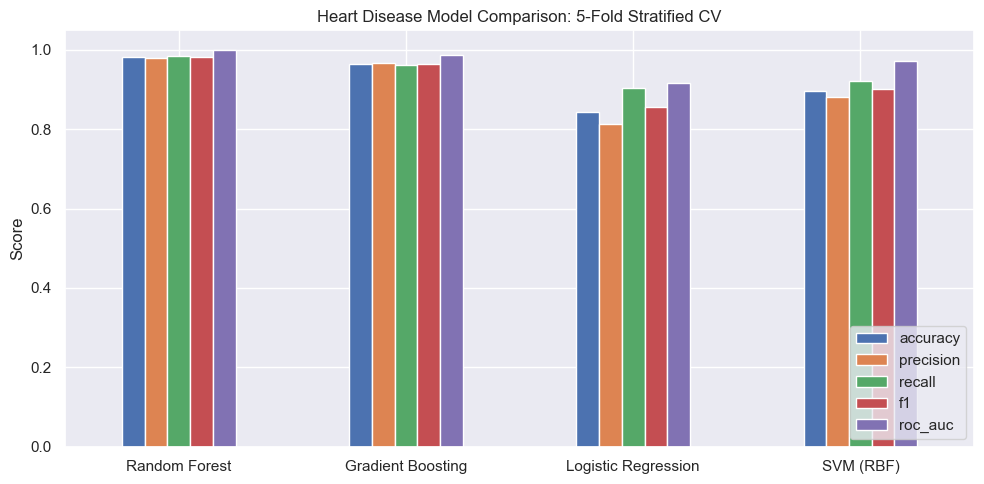

In [56]:
fig, ax = plt.subplots(figsize=(10, 5))
results_df.plot.bar(ax=ax, rot=0)
ax.set_ylabel('Score')
ax.set_title('Heart Disease Model Comparison: 5-Fold Stratified CV')
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()


In [57]:
# Holdout evaluation — prioritize recall (sensitivity) for clinical safety
best_name = results_df['recall'].idxmax()
best_pipe = models[best_name]
best_pipe.fit(X_train_s, y_train_s)

y_pred_s = best_pipe.predict(X_test_s)
y_proba_s = best_pipe.predict_proba(X_test_s)[:, 1]

print(f'Best model (by recall/sensitivity): {best_name}')
print()
print(classification_report(y_test_s, y_pred_s, target_names=['Healthy', 'Heart Disease']))
print(f'ROC-AUC: {roc_auc_score(y_test_s, y_proba_s):.4f}')
print(f'Brier Score: {brier_score_loss(y_test_s, y_proba_s):.4f} (lower is better)')


Best model (by recall/sensitivity): Random Forest

               precision    recall  f1-score   support

      Healthy       1.00      1.00      1.00       100
Heart Disease       1.00      1.00      1.00       105

     accuracy                           1.00       205
    macro avg       1.00      1.00      1.00       205
 weighted avg       1.00      1.00      1.00       205

ROC-AUC: 1.0000
Brier Score: 0.0070 (lower is better)


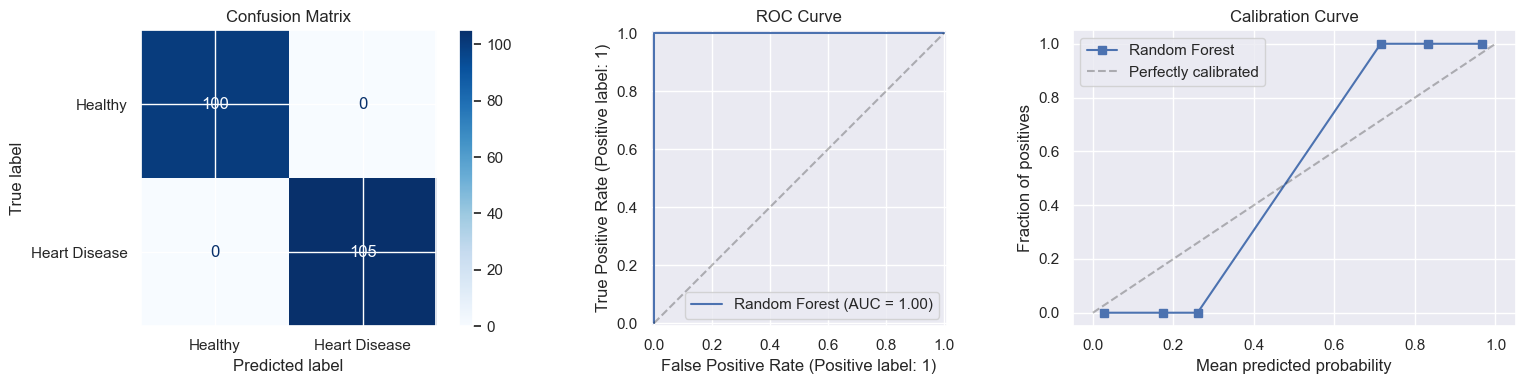

In [58]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_test_s, y_pred_s, display_labels=['Healthy', 'Heart Disease'],
    cmap='Blues', ax=axes[0]
)
axes[0].set_title('Confusion Matrix')

# ROC curve
RocCurveDisplay.from_predictions(y_test_s, y_proba_s, ax=axes[1], name=best_name)
axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.3)
axes[1].set_title('ROC Curve')

# Calibration curve
prob_true, prob_pred = calibration_curve(y_test_s, y_proba_s, n_bins=8)
axes[2].plot(prob_pred, prob_true, 's-', label=best_name)
axes[2].plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Perfectly calibrated')
axes[2].set_xlabel('Mean predicted probability')
axes[2].set_ylabel('Fraction of positives')
axes[2].set_title('Calibration Curve')
axes[2].legend()

plt.tight_layout()
plt.show()


## SHAP: Clinical feature importance

For a clinician to trust and act on model predictions, they need to see which
biometric factors drive the risk score. SHAP provides this transparency — essential
for clinical decision support systems.


In [59]:
try:
    import shap
    estimator = best_pipe.named_steps['clf']
    preprocessor = Pipeline(best_pipe.steps[:-1])
    X_train_t = preprocessor.transform(X_train_s)
    feature_names = X_s.columns.tolist()

    sample = X_train_t[:300]
    try:
        explainer = shap.TreeExplainer(estimator, sample)
    except Exception:
        explainer = shap.KernelExplainer(estimator.predict_proba, shap.sample(pd.DataFrame(sample), 50))
    shap_values = explainer.shap_values(sample)
    if isinstance(shap_values, list):
        shap_values = shap_values[1]

    fig, ax = plt.subplots(figsize=(10, 6))
    shap.summary_plot(shap_values, sample, feature_names=feature_names,
                      max_display=13, show=False)
    plt.title('SHAP: What Biometric Factors Drive Heart Disease Risk?')
    plt.tight_layout()
    plt.show()
except ImportError:
    print('Install shap: pip install shap')


Install shap: pip install shap


## Clinical recommendations

**For the cardiology department:**

1. **Use as a triage tool**, not a diagnostic. The model identifies high-risk
   patients for priority evaluation — it does not replace clinical judgment.

2. **Prioritize sensitivity (recall).** A missed heart disease case can be fatal.
   The model should err on the side of flagging patients for further testing.

3. **Calibration matters.** The calibration curve above shows how well predicted
   probabilities match actual outcomes. Well-calibrated probabilities enable
   risk-stratified care pathways (e.g., >70% risk → immediate cardiology referral,
   30–70% → stress test, <30% → routine monitoring).

4. **Key risk factors** (from SHAP): chest pain type, maximum heart rate, exercise-
   induced angina, and ST depression are the strongest predictors — consistent with
   established cardiology literature.

5. **Limitations:** This dataset (1,025 patients) is small. Before clinical deployment,
   validate on a larger, multi-center cohort and conduct a prospective study.
